<a href="https://colab.research.google.com/github/daa103/DAA_ESAA/blob/main/%EC%BA%90%EA%B8%80_%EC%9B%94%EA%B0%84_%EB%8D%B0%EC%9D%B4%EC%BD%98_%ED%95%9C%EA%B5%AD%EC%96%B4_%EB%AC%B8%EC%9E%A5_%EA%B4%80%EA%B3%84_%EB%B6%84%EB%A5%98_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ESAA OB 2조 프로젝트(2)**

[텍스트분석]

월간 데이콘 한국어 문장 관계 분류 AI 경진대회:
https://dacon.io/competitions/official/235875/overview/description

# 1. 패키지 불러오기

In [ ]:
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

!apt-get update -qq
!apt-get install fonts-nanum* -qq

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

matplotlib.rcParams['axes.unicode_minus'] = False

Selecting previously unselected package fonts-nanum.
(Reading database ... 120880 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
NanumBarunGothic


In [ ]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 35.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from glob import glob
import os
import numpy as np
from tqdm import tqdm, tqdm_notebook

from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

# 2. 데이터 불러오기

In [ ]:
from google import colab
colab.drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/ESAA_data/train_data.csv") #경로 반영
test = pd.read_csv("/content/drive/MyDrive/ESAA_data/test_data.csv")
submission = pd.read_csv("/content/drive/MyDrive/ESAA_data/sample_submission.csv")

In [ ]:
# train 데이터 상단 부분 확인
train.head()

,index,premise,hypothesis,label
0,0,"씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이...",씨름의 여자들의 놀이이다.,contradiction
1,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral


In [ ]:
# train 데이터 구조 파악
print(train.shape)
print(test.shape)
print(submission.shape)

(24998, 4)
(1666, 4)
(1666, 2)


# 3. 데이터 시각화

## 1) Train Target 분포 확인

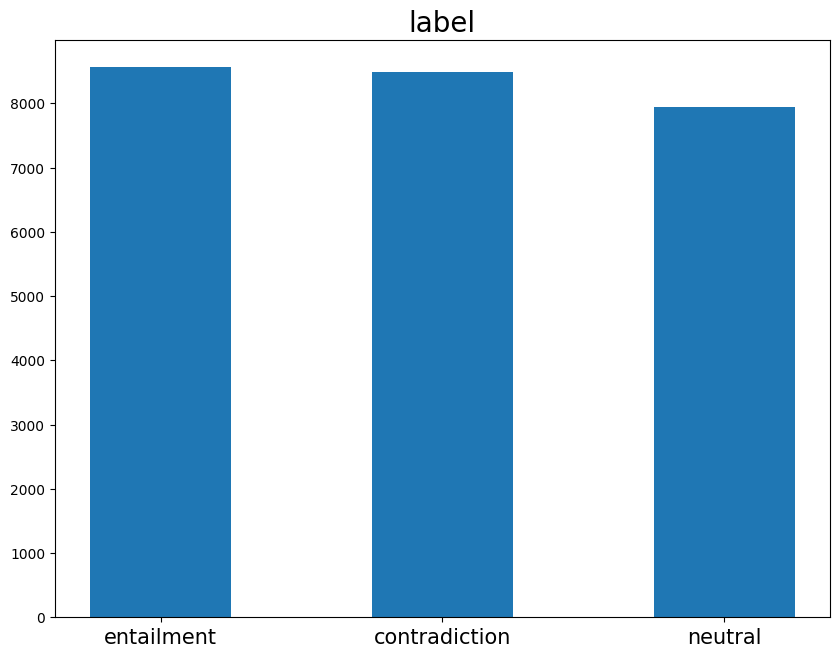

In [ ]:
# 히스토그램을 사용해서 데이터의 분포를 살펴봅니다.
feature = train['label']

plt.figure(figsize=(10,7.5)) # 그래프 이미지 크기 설정

plt.title('label', fontsize=20)
temp = feature.value_counts() # feature 변수의 변수별 개수 계산
plt.bar(temp.keys(), temp.values, width=0.5)
plt.xticks(temp.keys(), fontsize=15)
plt.show()

=> label이 일정하게 분포해 있다.

## 2) 실제 Text와 가설 Text의 평균 길이

In [ ]:
premise_len_mean = np.mean(train['premise'].str.len()) # 리뷰 길이의 평균값 계산
print('실제 Text 평균 길이 :',premise_len_mean)

hypo_len_mean = np.mean(train['hypothesis'].str.len()) # 리뷰 길이의 평균값 계산
print('가설 Text 평균 길이 :',hypo_len_mean)

실제 Text 평균 길이 : 45.406552524201935
가설 Text 평균 길이 : 24.924433954716378


=> 실제 Text의 평균 길이가 가설 Text의 평균 길이보다 길다.

### (1) 실제 Text 확인

In [ ]:
# 데이터 필터링을 위한 마스크 설정 (premise 부분만)
mask_true = (train.label == 'entailment')
mask_false = (train.label == 'contradiction')
mask_neutral = (train.label == 'neutral')

df_train = train.premise.copy()

df_true = train.loc[mask_true,:].premise
df_false = train.loc[mask_false,:].premise
df_neu = train.loc[mask_neutral,:].premise

# 세 집합을 리스트로 묶어줍니다.
compare = [df_train, df_true, df_false, df_neu]

In [ ]:
df_true.head()

2                       이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.
5     이번 증설로 코오롱인더스트리는 기존 생산량 7만7000톤에서 1만6800톤이 늘어나...
10                       대부분 도보로 이동하기 충분하다는 점이 매력적이었어요.
12                          영화 시작부터 끝까지 긴장감을 늦출 수가 없네요.
16    국토교통부는 연료보조금 지급 근거를 마련하기 위해 올해 하반기에 여객자동차 및 화물...
Name: premise, dtype: object

In [ ]:
df_false.head()

0    씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이...
1    삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...
7                           시대상황을 고려하는 현명한 시청태도가 요구되다.
8                    사진과 차이없는 아기자기한 실내소품들과 분위기가 멋졌습니다.
9                           빠른 답장과 간편한 체크인, 깨끗한 집 좋았어요
Name: premise, dtype: object

In [ ]:
df_neu.head()

3     광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...
4     진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...
6            자신뿐만 아니라 남을 돕고자 하는 청년의 꿈과 열정에 모두가 주목하고 있다.
11     오후에는 소흘읍민의 멋진 끼를 엿볼 수 있는 호수둘레길 버스킹 공연이 연이어 진행된다.
15                                상당히 많은 것을 내포하고 있는 영화.
Name: premise, dtype: object

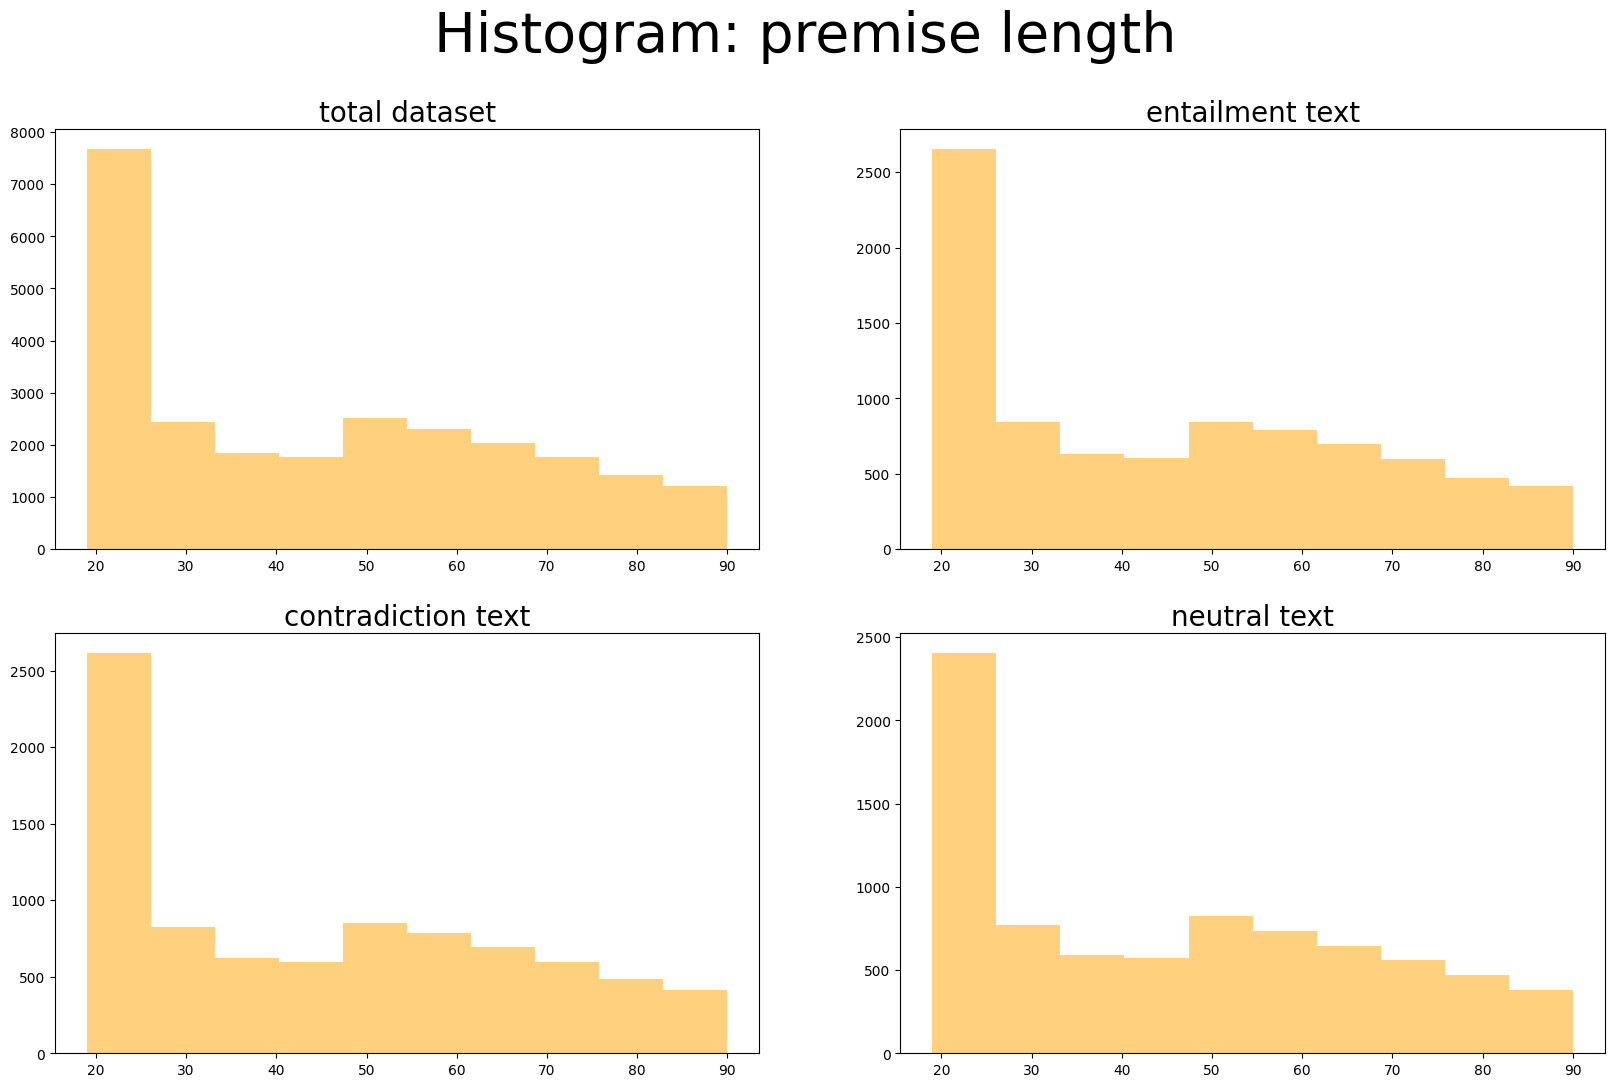

In [ ]:
# 히스토그램을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(20,12))
plt.suptitle("Histogram: premise length", fontsize=40)
name = ['total dataset', 'entailment text', 'contradiction text', 'neutral text']

for i in range(len(compare)):
    document = compare[i]
    string_len = [len(x) for x in document]
    # print(string_len)
    plt.subplot(2, 2, i+1)
    plt.title(name[i], fontsize=20)
    plt.hist(string_len, alpha=0.5, color='orange')

plt.show()

=> premise text의 경우 대부분 20~30자 사이에 분포해있고 최대 90자 정도까지 일정한 수치만큼 분포해 있다.

=> 실제 text인 premise는 label 값에 관계없이 동일 히스토그램을 보여주고 있다.

### (2) 가설 text 확인

In [ ]:
# 데이터 필터링을 위한 마스크 설정 (Hypothesis 부분만)
mask_true = (train.label == 'entailment')
mask_false = (train.label == 'contradiction')
mask_neutral = (train.label == 'neutral')

df_train = train.hypothesis .copy()

df_true = train.loc[mask_true,:].hypothesis
df_false = train.loc[mask_false,:].hypothesis
df_neu = train.loc[mask_neutral,:].hypothesis

# 세 집합을 리스트로 묶어줍니다.
compare = [df_train, df_true, df_false, df_neu]

In [ ]:
df_true.head()

2     예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.
5         코오롱 인더스트리는 총 9만 3800톤의 생산 능력을 확보했다.
10                            대부분 걸어서 갈수 있어요.
12                        영화 시작부터 긴장감이 함께하네요.
16      여객자동차 및 화물자동차 운수사업법을 국토교통부가 개정할 계획이다.
Name: hypothesis, dtype: object

In [ ]:
df_false.head()

0                       씨름의 여자들의 놀이이다.
1                     자작극을 벌인 이는 3명이다.
7                   시청태도에 특별한 주의점은 없다.
8    아기자기한 실내소품들은 사진에서 본 것과 차이가 있었습니다.
9                          체크인이 복잡했어요.
Name: hypothesis, dtype: object

In [ ]:
df_neu.head()

3                      원주민들은 종합대책에 만족했다.
4     이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.
6                  모든 청년은 꿈과 열정을 가지고 있다.
11           호수둘레길 버스킹 공연에 많은 군민들이 참석했다.
15            인간의 감정에 대한 내용을 내포하고 있는 영화.
Name: hypothesis, dtype: object

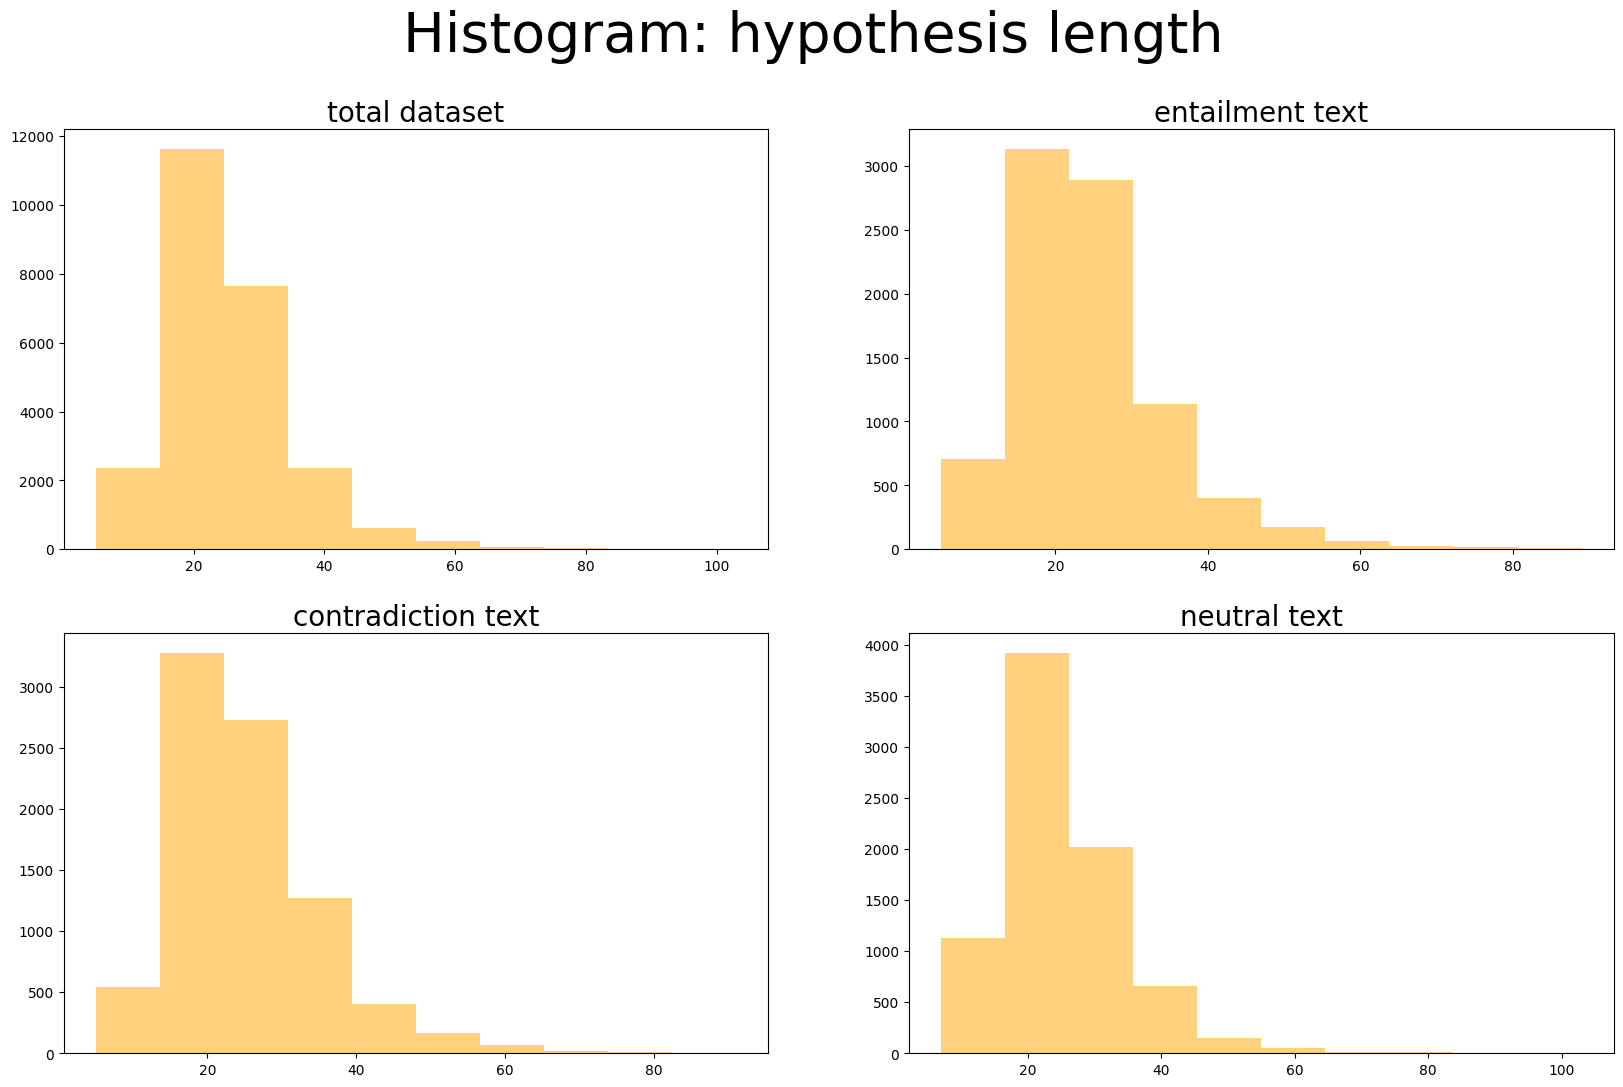

In [ ]:
# 히스토그램을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(20,12))
plt.suptitle("Histogram: hypothesis length", fontsize=40)
name = ['total dataset', 'entailment text', 'contradiction text', 'neutral text']

for i in range(len(compare)):
    document = compare[i]
    string_len = [len(x) for x in document]
    plt.subplot(2, 2, i+1)
    plt.title(name[i], fontsize=20)
    plt.hist(string_len, alpha=0.5, color='orange')

plt.show()

=> 가설 text는 label 값에 따라 어느 정도 차이를 보여주지만 역시 20자 정도에 많이 분포해 있는 모습이다.

=> 알 수 없는 문장은 참, 거짓에 비해 상대적으로 적은 양을 가지고도 가설 문장의 참/거짓/알수없다를 판별해내야 한다.


## 3) Word Cloud

In [ ]:
def df2str(df):
    # 전체 리뷰들을 하나의 문자열로 만듦
    s = [s for s in df]
    document = ""
    for i in range(len(s)):
        document += s[i]
    return document

def get_noun(text):
    # okt tagger를 이용해 명사 추출
    okt = Okt()
    noun = okt.nouns(text)
    for i,v in enumerate(noun):
        if len(v)<2:
            noun.pop(i)
    count = Counter(noun)
    noun_list = count.most_common(100)

    return noun_list

def visualize(noun_list, title):
    # 워드클라우드 이미지 생성
    wc= WordCloud(
        background_color='white', # 배경 색깔 정하기
        colormap = 'Dark2', # 폰트 색깔 정하기
        font_path = font_path,
        width = 800,
        height = 800).generate_from_frequencies(dict(noun_list))

    plt.figure(figsize=(10,10)) # 이미지 사이즈 지정
    plt.title(title, fontsize=20)
    plt.imshow(wc, interpolation='lanczos') # 이미지의 부드럽기 정도
    plt.axis('off') # x y 축 숫자 제거
    plt.show()  # 워드클라우드 이미지 확인

    return wc

In [ ]:
document = df2str(df_train) # 전체 리뷰들을 하나의 문자열로 만듦
noun_list = get_noun(document) # 명사 추출, 개수 셈
noun_list[:10]

[('영화', 2053),
 ('숙소', 713),
 ('사람', 539),
 ('호스트', 443),
 ('위치', 421),
 ('사업', 401),
 ('대한', 342),
 ('가장', 336),
 ('지원', 328),
 ('예정', 316)]

## 1) Total_text

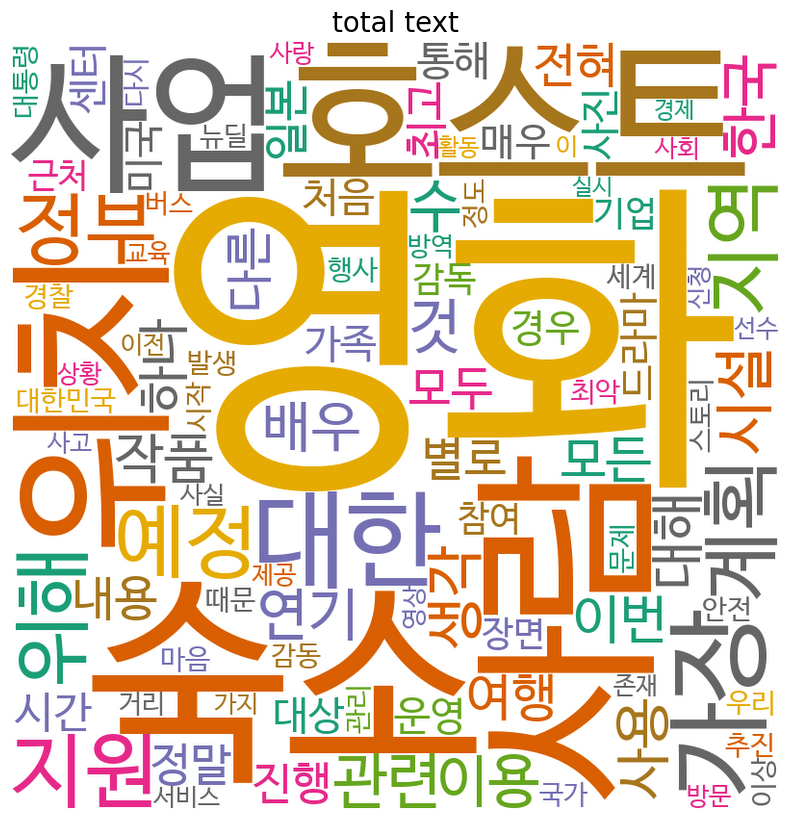

In [ ]:
total_text = visualize(noun_list,'total text') # 워드클라우드 시각화

=> 가설 문장의 참/거짓을 확인하기 어려움.

=> 영화가 크게 있는 걸 보면 영화 기사나 리뷰 글에서 나온 문장들도 있는 건가 궁금하다.

=> 전체적으로 Word Cloud 실행


## 2) Entailment
- Premise text를 label에 따라 Word Cloud

In [ ]:
# Entailment
document = df2str(df_true) # 전체 리뷰들을 하나의 문자열로 만듦
noun_list = get_noun(document) # 명사 추출, 개수 셈
noun_list[:10]

[('영화', 700),
 ('숙소', 244),
 ('사람', 182),
 ('위치', 169),
 ('사업', 149),
 ('호스트', 146),
 ('위해', 122),
 ('지원', 122),
 ('시설', 111),
 ('수', 108)]

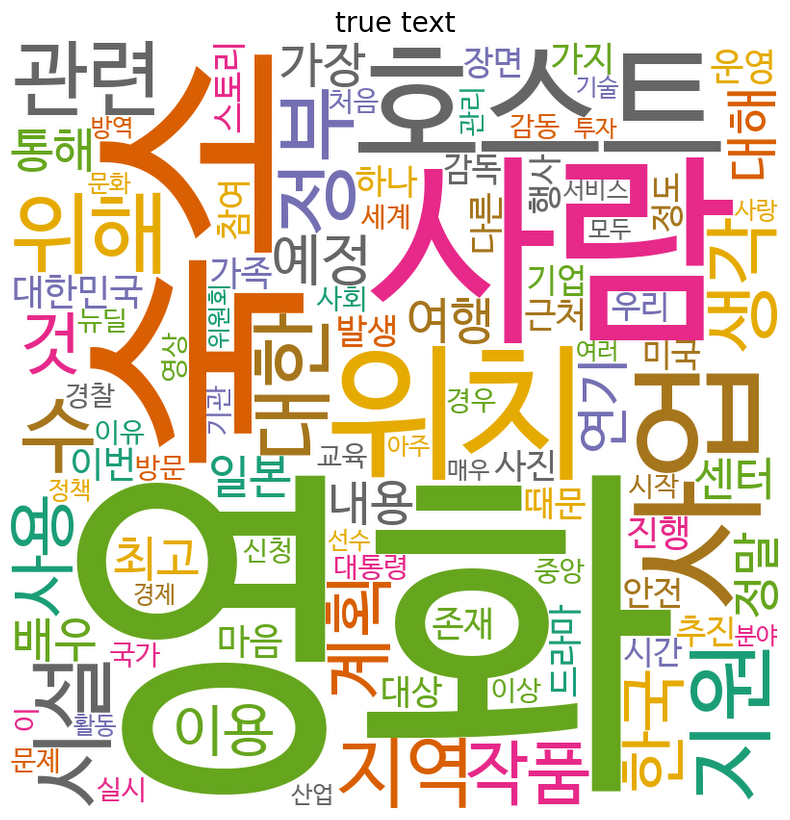

In [ ]:
true_text = visualize(noun_list,'true text') # 워드클라우드 시각화

=> 라벨 구분 없이 Word Cloud를 진행했을 때랑 비슷한 형태가 나온다.

=> 숙소, 사업, 위치, 호스트, 영화 이런 단어들은 제외해도 될 것 같다.

## 3) Contradiction

In [ ]:
# Contradiction
document = df2str(df_false) # 전체 리뷰들을 하나의 문자열로 만듦
noun_list = get_noun(document) # 명사 추출, 개수 셈
noun_list[:10]

[('영화', 700),
 ('숙소', 238),
 ('전혀', 198),
 ('사람', 181),
 ('별로', 165),
 ('위치', 146),
 ('호스트', 144),
 ('사업', 142),
 ('관련', 130),
 ('대한', 126)]

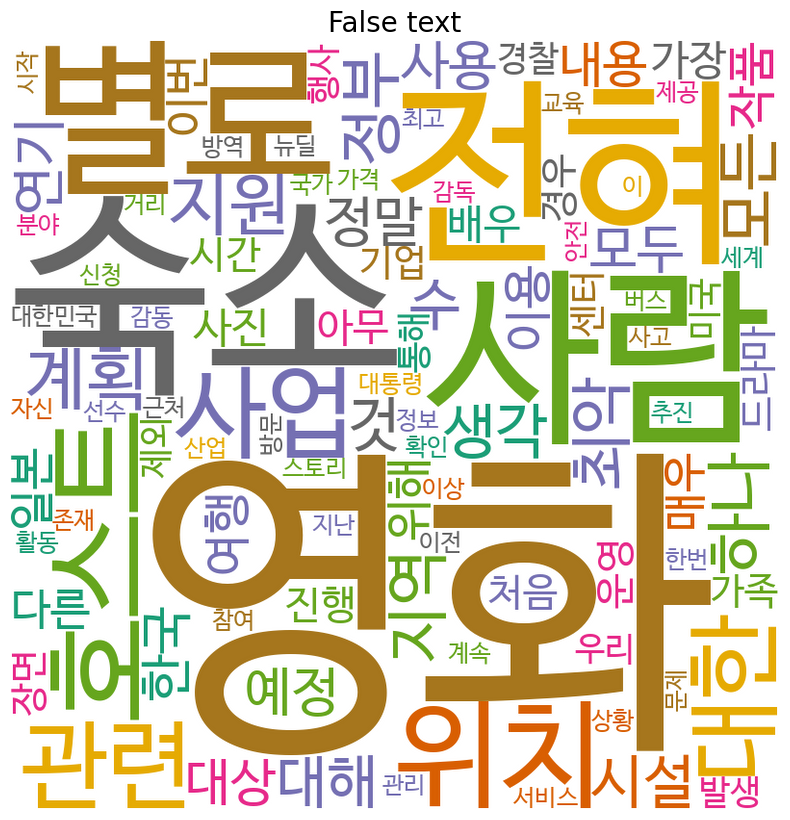

In [ ]:
false_text = visualize(noun_list,'False text') # 워드클라우드 시각화

=> 가설이 참인 문장을 워드클라우드 했을 때와 비슷한 형태인 것으로 보여진다.

## 4) Neutral

In [ ]:
# Neutral
document = df2str(df_neu) # 전체 리뷰들을 하나의 문자열로 만듦
noun_list = get_noun(document) # 명사 추출, 개수 셈
noun_list[:10]

[('영화', 653),
 ('숙소', 231),
 ('가장', 192),
 ('사람', 176),
 ('호스트', 153),
 ('예정', 140),
 ('위해', 113),
 ('대한', 110),
 ('사업', 110),
 ('위치', 106)]

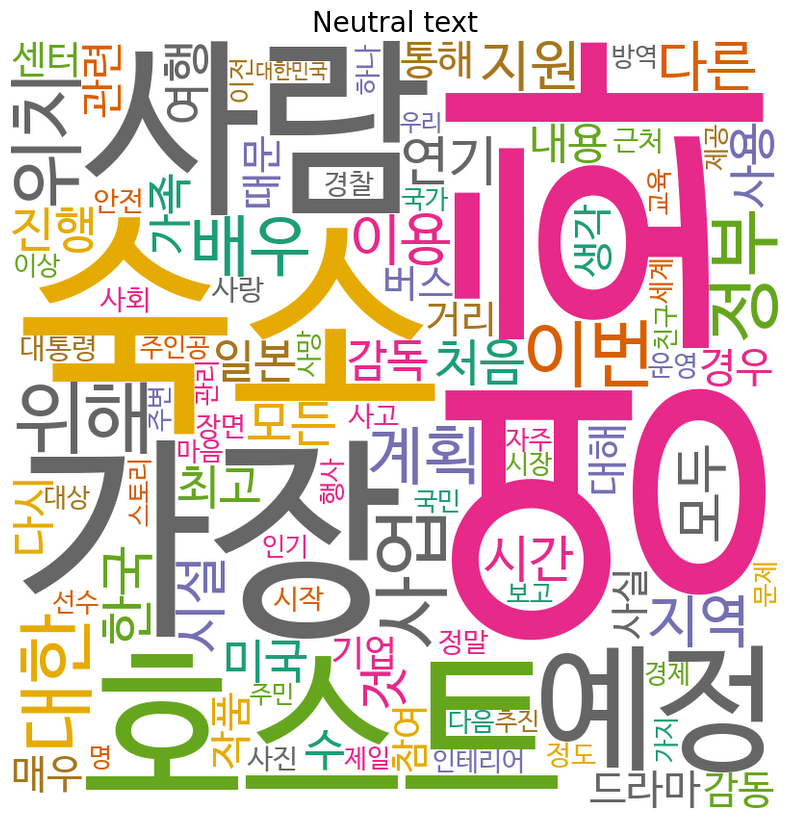

In [ ]:
neutral_text = visualize(noun_list,'Neutral text') # 워드클라우드 시각화

## 5) Hypothesis text를 label에 따라 Word Cloud

### (1) Entailment

In [ ]:
df_hy_train = train.hypothesis.copy()

df_hy_true = train.loc[mask_true,:].hypothesis
df_hy_false = train.loc[mask_false,:].hypothesis
df_hy_neu = train.loc[mask_neutral,:].hypothesis

In [ ]:
document = df2str(df_hy_true) # 전체 리뷰들을 하나의 문자열로 만듦
noun_list = get_noun(document) # 명사 추출, 개수 셈
noun_list[:10]

[('영화', 700),
 ('숙소', 244),
 ('사람', 182),
 ('위치', 169),
 ('사업', 149),
 ('호스트', 146),
 ('위해', 122),
 ('지원', 122),
 ('시설', 111),
 ('수', 108)]

### (2) Contradiction

In [ ]:
document = df2str(df_hy_false) # 전체 리뷰들을 하나의 문자열로 만듦
noun_list = get_noun(document) # 명사 추출, 개수 셈
noun_list[:10]

[('영화', 700),
 ('숙소', 238),
 ('전혀', 198),
 ('사람', 181),
 ('별로', 165),
 ('위치', 146),
 ('호스트', 144),
 ('사업', 142),
 ('관련', 130),
 ('대한', 126)]

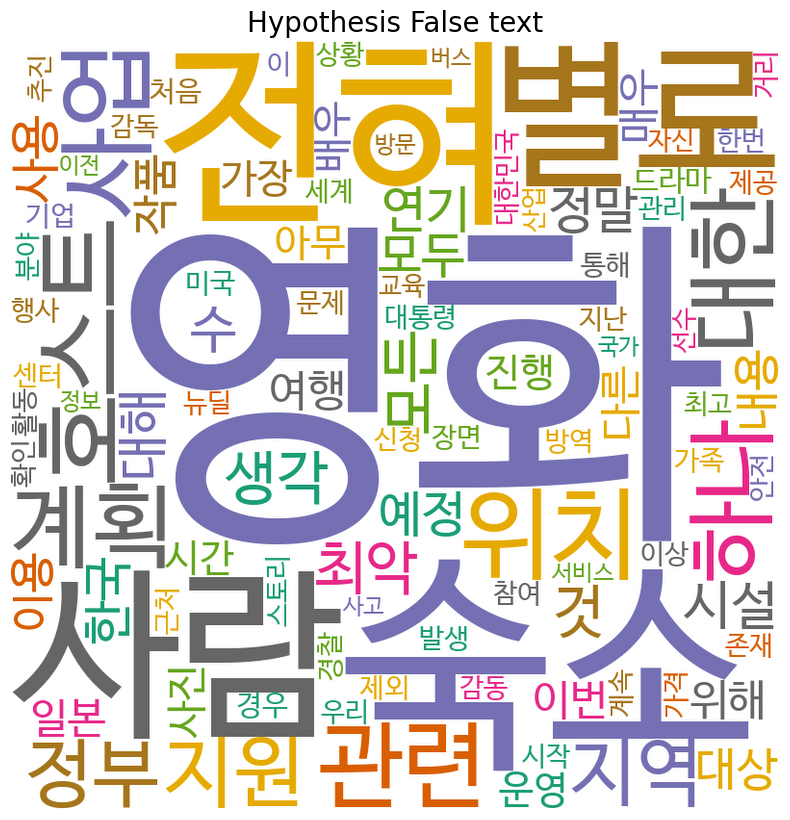

In [ ]:
false_text = visualize(noun_list,'Hypothesis False text') # 워드클라우드 시각화

### (3) Neutral

In [ ]:
document = df2str(df_hy_neu) # 전체 리뷰들을 하나의 문자열로 만듦
noun_list = get_noun(document) # 명사 추출, 개수 셈
noun_list[:10]

[('영화', 653),
 ('숙소', 231),
 ('가장', 192),
 ('사람', 176),
 ('호스트', 153),
 ('예정', 140),
 ('위해', 113),
 ('대한', 110),
 ('사업', 110),
 ('위치', 106)]

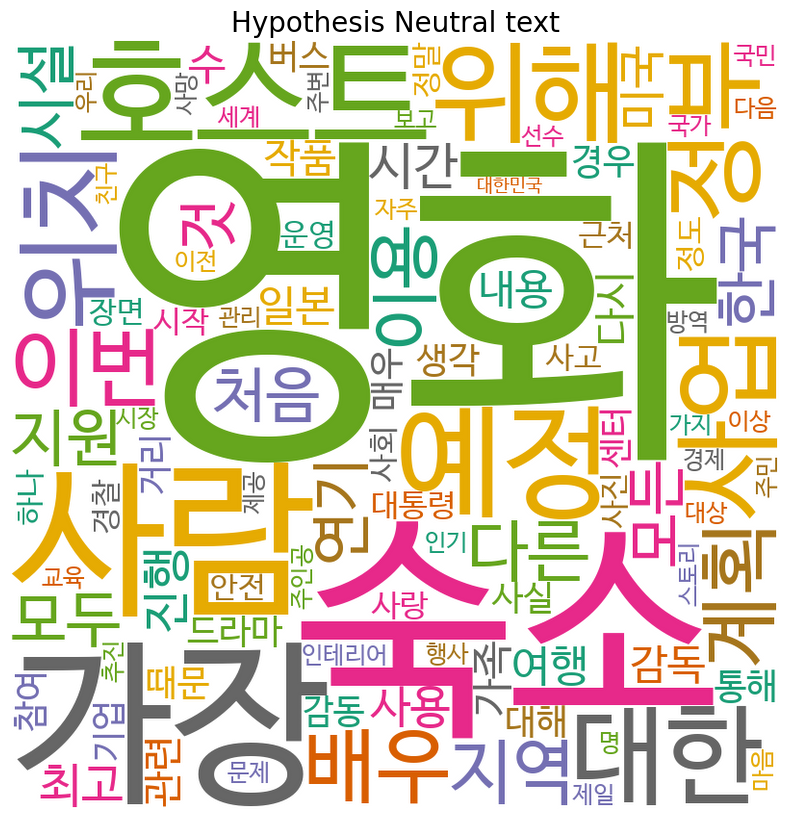

In [ ]:
neutral_text = visualize(noun_list,'Hypothesis Neutral text') # 워드클라우드 시각화

<전처리>

1. 라이브러리, 패키지 불러오기

In [ ]:
!pip install datasets transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the followin line:
!pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 6.0 MB/s eta 0:00:00
ERROR: torch_xla-1.9-cp37-cp37m-linux_x86_64.whl is not a supported wheel on this platform.


In [ ]:
#TPU 사용을 위한 accelerate
from accelerate import Accelerator

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from transformers import TrainingArguments, Trainer
from transformers import AutoModel,AutoModelForSequenceClassification, AutoConfig, AutoTokenizer
import gc
from transformers import AdamW
from transformers import get_scheduler, get_cosine_with_hard_restarts_schedule_with_warmup
from tqdm.auto import tqdm
from datasets import load_metric
import warnings
warnings.filterwarnings('ignore')
from accelerate import notebook_launcher

2. 데이터셋 만들기 ( 데이콘+카카오+KLUE :추가로 2가지 데이터 다운 받아옴)




```
train = pd.read_csv('/content/drive/MyDrive/train_data.csv', encoding='utf-8')

test = pd.read_csv('/content/drive/MyDrive/test_data.csv', encoding='utf-8')

만약 추가적인 데이터 안불러올 때의 코드.
```



In [ ]:
# 데이콘 데이터셋
train = pd.read_csv("/content/drive/MyDrive/ESAA_data/train_data.csv") #경로 반영
test = pd.read_csv("/content/drive/MyDrive/ESAA_data/test_data.csv")

# 카카오 데이터셋
kakao_snli = pd.read_csv('/content/drive/MyDrive/ESAA_data/snli_1.0_train.ko.tsv', sep='\t', encoding='utf-8')
kakao_snli = kakao_snli[:100000]
kakao_dev = pd.read_csv('/content/drive/MyDrive/ESAA_data/xnli.dev.ko.tsv', sep='\t', encoding='utf-8')
kakao_test = pd.read_csv('/content/drive/MyDrive/ESAA_data/xnli.test.ko.tsv', sep='\t', encoding='utf-8')
kakao_dev = pd.concat([kakao_dev,kakao_test, kakao_snli])
kakao_dev.rename(columns = {'sentence1':'premise','sentence2':'hypothesis','gold_label':'label'},inplace=True)

# KLUE 데이터셋
klue_dev = pd.read_json('/content/drive/MyDrive/ESAA_data/klue-nli-v1.1_dev.json')
klue_dev = klue_dev[['premise', 'hypothesis', 'gold_label']]
klue_dev.rename(columns = {'gold_label':'label'}, inplace=True)

# 데이콘, 카카오, KLUE 데이터셋 병합
train = pd.concat([train, klue_dev, kakao_dev], axis=0)
train = train.reset_index(drop=True)
train['index'] = train.index
train = train.dropna()
train = train.reset_index(drop=True)
train['index'] = train.index
train

,index,premise,hypothesis,label
0,0,"씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이...",씨름의 여자들의 놀이이다.,contradiction
1,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral
...,...,...,...,...
134514,134514,같은 방향으로 보이는 숲이 우거진 지역에 의상을 입은 사람들이 모여 있다.,사람들은 의상을 입는다,entailment
134515,134515,검은 원피스에 커다란 흰 활을 든 소녀가 카메라를 등지고 서 있다.,하이힐을 신은 남자,contradiction
134516,134516,검은 원피스에 커다란 흰 활을 든 소녀가 카메라를 등지고 서 있다.,서 있는 소녀,entailment
134517,134517,검은 원피스에 커다란 흰 활을 든 소녀가 카메라를 등지고 서 있다.,사진 촬영 준비를 하고 있는 소녀,neutral


-> 데이터는 동일한 premise에 세 가지의 hypothesis로 구성. 각각의 hypothesis는 대체로 contradiction, entailment, neutral이 하나씩 매칭

-> train, test data 확인

In [ ]:
print(train.info(), end='\n\n')
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134519 entries, 0 to 134518
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   index       134519 non-null  int64 
 1   premise     134519 non-null  object
 2   hypothesis  134519 non-null  object
 3   label       134519 non-null  object
dtypes: int64(1), object(3)
memory usage: 4.1+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1666 entries, 0 to 1665
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       1666 non-null   int64 
 1   premise     1666 non-null   object
 2   hypothesis  1666 non-null   object
 3   label       1666 non-null   object
dtypes: int64(1), object(3)
memory usage: 52.2+ KB
None


In [ ]:
print('Train Columns: ', train.columns)
print('Test Columns: ', test.columns)

Train Columns:  Index(['index', 'premise', 'hypothesis', 'label'], dtype='object')
Test Columns:  Index(['index', 'premise', 'hypothesis', 'label'], dtype='object')


In [ ]:
print('Train Label: ', train['label'].value_counts(), sep='\n', end='\n\n')
print('Test Label: ', test['label'].value_counts(), sep='\n')

Train Label: 
entailment       45068
contradiction    44997
neutral          44454
Name: label, dtype: int64

Test Label: 
answer    1666
Name: label, dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

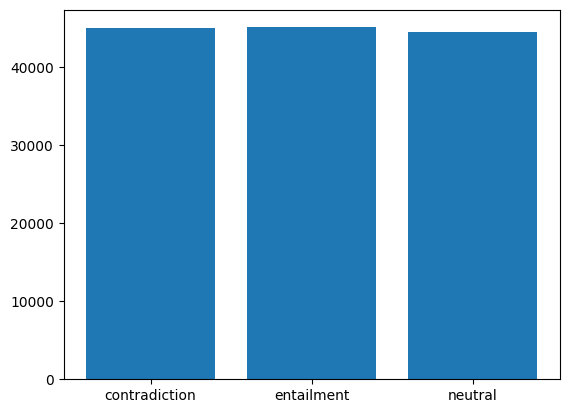

In [ ]:
num_contradiction = len(train[train['label'] == 'contradiction'])
num_entailment = len(train[train['label'] == 'entailment'])
num_neutral = len(train[train['label'] == 'neutral'])

labels = ['contradiction', 'entailment', 'neutral']
counts = [num_contradiction, num_entailment, num_neutral]

plt.bar(labels, counts)
plt.show

-> train셋의 label은 contradiction, entailment, neutral이 고르게 분포

In [ ]:
print('Train Null: ', train.isnull().sum(), sep='\n', end='\n\n')
print('Test Null: ', test.isnull().sum(), sep='\n')

Train Null: 
index         0
premise       0
hypothesis    0
label         0
dtype: int64

Test Null: 
index         0
premise       0
hypothesis    0
label         0
dtype: int64


-> null 값 없음

In [ ]:
for i, sent in enumerate(train['premise'].unique()):
  if len(train[train['premise'] == sent]) == 3:
    continue
  else :
    print('value',sent)
    print(i)

value 국립공원 내 다중이용시설이 방역 및 운영 여건을 감안하여 23일부터 운영을 재개한다.
74
value 지난 1964년 1차 인민혁명당 사건에서 유죄 판결을 받았던 관련자들이 48년만의 재심에서 무죄를 선고받았다.
78
value 아름답고 거대한 대자연 앞에 무의미한 인종갈등
129
value 구독자가 관심있는 유용한 정보와 상업적 정보를 동시에 전달하는 뉴닉의 브랜디드 콘텐츠가 한편으론 광고라는 사실을 축소하는 것처럼 비춰질 수 있기 때문이다.
140
value 큰 창과 아기자기한 방이 인상적이었습니다.
206
value 최선정 정신병원 입원하는걸로 끝나겠어요
216
value 네 가지 무기로 이제 충분히 싸울만합니다.
448
value 마지막 3일에는 성윤모 산업통상자원부 장관, 박양우 문화체육관광부 장관, 김현수 농림축산식품부 장관이 각각 출연, 비대면 소비문화 확산에 일조할 계획이다.
450
value 이를 위해 미세먼지를 줄이기 위한 숲 조성, 서울시와의 전기이륜차 교체 업무협약를 체결하는 등 적극적인 친환경 행보를 내딛고 있다.
478
value 이 과정을 통해 오래되고 필요 없는 단백질이 함께 분해되는데 이 과정을 통해 세포가 스스로 건강을 유지해나간다는 이론이다.
818
value 매우 깨끗하고 인테리어도 너무 이뻐요.
821
value 신 씨 친구는 오전 7시쯤 자살 암시 내용이 담긴 예약 문자를 받았다며 경찰에 신고했다.
896
value 나폴레옹 전쟁 중인 1805년 영국 군함 서프라이즈 호의 잭 오브리 함장은 프랑스 무장선 아케론 호를 나포하거나 파괴하라는 명령을 받는다.
921
value 파티를 끝낸 후 브랜든과 필립은 데이비드의 시체를 자신들의 차로 옮기려 한다.
1145
value 즉석조리식품 이외에도 베트남에서는 아직 익숙하지 않은 상품인 삼각김밥, 도시락과 같은 신선식품도 지속해서 매출이 늘고 있다.
1306
value 매체는 두 장면을 꼬집으며 모욕적이고 불쾌하다고 꼬집었다.
1321
value 지난 19일, 26일 관

-> -> 세 가지의 hypothesis를 가지지 않은 premise -> 삭제? 남겨둠?

- label_num 칼럼 추가

-> "entailment": 0, "contradiction": 1, "neutral": 2, "answer": 3 으로 지정

In [ ]:
def label_to_num(label):
    label_dict = {"entailment": 0, "contradiction": 1, "neutral": 2, "answer": 3}
    num_label = []

    for v in label:
        num_label.append(label_dict[v])

    return num_label

In [ ]:
label_num = label_to_num(train['label'])
train['label_num']=label_num
train.head()

,index,premise,hypothesis,label,label_num
0,0,"씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이...",씨름의 여자들의 놀이이다.,contradiction,1
1,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction,1
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment,0
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral,2
4,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral,2


3. 함수 생성

In [ ]:
# "klue/roberta-large" 모델: KLUE (Korean Language Understanding Evaluation) 벤치마크를 위해 훈련된 RoBERTa 모델의 큰 버전

from transformers import AutoTokenizer

checkpoint = 'klue/roberta-large'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/752k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [ ]:
token_map = tokenizer.special_tokens_map
token_map

{'bos_token': '[CLS]',
 'eos_token': '[SEP]',
 'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [ ]:
# BERT 모델의 훈련 또는 평가를 위해 데이터를 준비하는 데 사용

class BERTDataset(torch.utils.data.Dataset):
    def __init__(self, pair_dataset, label):
        self.pair_dataset = pair_dataset
        self.label = label

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.pair_dataset.items()}
        item['labels'] = torch.tensor(self.label[idx])

        return item

    def __len__(self):
        return len(self.label)

In [ ]:
# 모델의 정확도(accuracy)를 계산

def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
train.drop('index', axis = 1,inplace = True)

### #1 모델링- Koelectra1+2epoch학습

1

In [ ]:
# ignore warning message
import warnings
warnings.filterwarnings("ignore")

# seed, preprocessing, for time check
from tqdm import tqdm, tqdm_notebook
import time
import random
import pandas as pd
import numpy as np
import re
from collections import Counter

# modeling
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

from transformers import AutoTokenizer, ElectraForSequenceClassification, AutoModel, AutoModelForSequenceClassification
from transformers import AdamWeightDecay, AdamW
from transformers.optimization import get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup

In [ ]:
def get_seed(seed:int = 2022):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

get_seed(42)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
def prep_dat():

    ## get train
    # 데이콘 데이터셋
    train = pd.read_csv("/content/drive/MyDrive/ESAA_data/train_data.csv") #경로 반영
    train.drop(['index'], axis=1, inplace=True)


    ## get test and submission
    test = pd.read_csv("/content/drive/MyDrive/ESAA_data/test_data.csv")
    sub = pd.read_csv('/content/drive/MyDrive/ESAA_data/sample_submission.csv')


    # train = pd.concat([train,kornli_train], ignore_index=True, join='inner')
    train.dropna(inplace=True)
    train.drop_duplicates(inplace=True,ignore_index=True)

    ## matching label
    label_match = {"entailment" : 0, "contradiction" : 1, "neutral" : 2}
    train['label'] = train['label'].map(label_match)

    ## re : 1
    train['premise'] = train['premise'].map(lambda x: re.sub('[-=+.,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', x))
    train['hypothesis'] = train['hypothesis'].map(lambda x: re.sub('[-=+.,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', x))
    test['premise'] = test['premise'].map(lambda x: re.sub('[-=+.,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', x))
    test['hypothesis'] = test['hypothesis'].map(lambda x: re.sub('[-=+.,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', x))

    ## re : 2
    train['premise'] = train['premise'].map(lambda x: re.sub('[-=+,#:;//●<>▲\?:^$.☆!★()Ⅰ@*\"※~>`\'…》→←]', '', x))
    train['hypothesis'] = train['hypothesis'].map(lambda x: re.sub('[-=+,#:;//●<>▲\?:^$.☆!★()Ⅰ@*\"※~>`\'…》→←]', '', x))
    test['premise'] = test['premise'].map(lambda x: re.sub('[-=+,#:;//●<>▲\?:^$.☆!★()Ⅰ@*\"※~>`\'…》→←]', '', x))
    test['hypothesis'] = test['hypothesis'].map(lambda x: re.sub('[-=+,#:;//●<>▲\?:^$.☆!★()Ⅰ@*\"※~>`\'…》→←]', '', x))

    return train,test,sub

def correct_token(dat):
    dat['token_sen'] = "[CLS]" + dat["premise"] + "[SEP]" + " " + dat["hypothesis"] + "[SEP]"
    dat = dat[['token_sen','label']]
    return dat

In [ ]:
## get DATA
train, test, sub = prep_dat()
correct_train, correct_test = correct_token(train), correct_token(test)

## token size를 100으로 결정
max_len = np.max(train['premise'].str.len())
min_len = np.min(train['premise'].str.len())
mean_len = np.mean(train['premise'].str.len())

print('Max Premise Length: ', max_len)
print('Min Premise Length: ', min_len)
print('Mean Premise Lenght: ', mean_len, '\n')

max_len = np.max(train['hypothesis'].str.len())
min_len = np.min(train['hypothesis'].str.len())
mean_len = np.mean(train['hypothesis'].str.len())

print('Max Hypothesis Length: ', max_len)
print('Min Hypothesis Length: ', min_len)
print('Mean Hypothesis Lenght: ', mean_len)

Max Premise Length:  89
Min Premise Length:  18
Mean Premise Lenght:  44.2370779324692 

Max Hypothesis Length:  102
Min Hypothesis Length:  4
Mean Hypothesis Lenght:  23.899663946231396


In [ ]:
class NLIDataset(Dataset):

  def __init__(self, dataset, option, modelname):
    self.dataset = dataset
    self.option = option
    self.tokenizer = AutoTokenizer.from_pretrained(modelname)

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    row = self.dataset.iloc[idx, 0:2].values
    text = row[0]

    inputs = self.tokenizer(
        text,
        return_tensors='pt',
        max_length=100,
        truncation=True,
        pad_to_max_length=True,
        add_special_tokens=False
        )

    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]

    if self.option =='train':
        y = row[1]
        return input_ids, attention_mask, y

    return input_ids, attention_mask

In [ ]:
## DEFINE MODEL PARA
# model_name = 'klue/roberta-large'
model_name = 'monologg/koelectra-base-v3-discriminator'
num_epochs = 2
batch_size = 10
lr = 1e-5

## get DATA
train, test, sub = prep_dat()
correct_train, correct_test = correct_token(train), correct_token(test)
train_dataset = NLIDataset(correct_train, 'train', model_name)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## DECLARE MODEL
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
model = nn.DataParallel(model).to(device)

optimizer = AdamW(model.parameters(), lr=lr, eps = 1e-8)
warmup_ratio = 0.1
total_steps = len(train_loader) * num_epochs
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=total_steps)


## TRAINING PROCESS
start_time = time.time()
for epoch in tqdm(range(num_epochs)):
    print('-------------------------------------- Training Begin! --------------------------------------')
    batch_num = 0; eq_sum = 0; y_len =0

    model.train()

    for input_ids_batch, attention_masks_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_batch = y_batch.to(device)
        y_pred = model(input_ids_batch.to(device), attention_mask = attention_masks_batch.to(device))[0]
        loss = F.cross_entropy(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        scheduler.step()
        _, predicted = torch.max(y_pred, 1)
        eq_sum += (predicted == y_batch).sum()
        y_len += len(y_batch)

        # CHECK PROCESS
        batch_num += 1
        if batch_num % 100 == 0:
            acc = eq_sum.float() / y_len
            print(f'BATCH_NUM : {batch_num}, TRAIN_LOSS : {loss.item():.4f}, TRAIN_ACC : {acc.item():.4f}')
        if batch_num % 1000 == 0:
            print(f'FOR 1000 EPOCH : {time.time() - start_time} SECONDS!')
            start_time = time.time()

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/2 [00:00<?, ?it/s]

-------------------------------------- Training Begin! --------------------------------------
BATCH_NUM : 100, TRAIN_LOSS : 1.1169, TRAIN_ACC : 0.3580
BATCH_NUM : 200, TRAIN_LOSS : 1.1041, TRAIN_ACC : 0.3545
BATCH_NUM : 300, TRAIN_LOSS : 1.1176, TRAIN_ACC : 0.3867
BATCH_NUM : 400, TRAIN_LOSS : 0.7635, TRAIN_ACC : 0.4493
BATCH_NUM : 500, TRAIN_LOSS : 0.4644, TRAIN_ACC : 0.5106
BATCH_NUM : 600, TRAIN_LOSS : 0.2714, TRAIN_ACC : 0.5567
BATCH_NUM : 700, TRAIN_LOSS : 0.5462, TRAIN_ACC : 0.5909
BATCH_NUM : 800, TRAIN_LOSS : 0.3705, TRAIN_ACC : 0.6199
BATCH_NUM : 900, TRAIN_LOSS : 0.5643, TRAIN_ACC : 0.6398
BATCH_NUM : 1000, TRAIN_LOSS : 0.8379, TRAIN_ACC : 0.6571
FOR 1000 EPOCH : 11747.168271541595 SECONDS!
BATCH_NUM : 1100, TRAIN_LOSS : 0.9457, TRAIN_ACC : 0.6712
BATCH_NUM : 1200, TRAIN_LOSS : 0.6545, TRAIN_ACC : 0.6837
BATCH_NUM : 1300, TRAIN_LOSS : 0.1596, TRAIN_ACC : 0.6954
BATCH_NUM : 1400, TRAIN_LOSS : 0.5607, TRAIN_ACC : 0.7055
BATCH_NUM : 1500, TRAIN_LOSS : 0.2817, TRAIN_ACC : 0.7144


 50%|█████     | 1/2 [8:06:39<8:06:39, 29199.28s/it]

BATCH_NUM : 2500, TRAIN_LOSS : 0.1497, TRAIN_ACC : 0.7667
-------------------------------------- Training Begin! --------------------------------------
BATCH_NUM : 100, TRAIN_LOSS : 0.3823, TRAIN_ACC : 0.9030
BATCH_NUM : 200, TRAIN_LOSS : 0.2947, TRAIN_ACC : 0.9060
BATCH_NUM : 300, TRAIN_LOSS : 0.1651, TRAIN_ACC : 0.9117
BATCH_NUM : 400, TRAIN_LOSS : 0.2878, TRAIN_ACC : 0.9107
BATCH_NUM : 500, TRAIN_LOSS : 0.2231, TRAIN_ACC : 0.9102
BATCH_NUM : 600, TRAIN_LOSS : 0.2636, TRAIN_ACC : 0.9102
BATCH_NUM : 700, TRAIN_LOSS : 0.1832, TRAIN_ACC : 0.9106


In [ ]:
torch.save(model, './model/upload_model2.pth')